# Closed system simulation with experimental data markers

In this simulation we have a system of 5 liters in which we start with Next = 1000/500/200, some Nint (measured) of some mass (m). After this we "feed" for a period of 7/3.5/2.33 days, i.e. solve the "feeding" part of the simulation. After that, we add 1000/500/200 uM to the last value of Next and keep "feeding". After one duration (7 days) we reset the water, mass and the amplitude to the beginning of the first cycle. The only difference from the t_0 is the Nint which is accumulating all the effects through the time. The mass is reset to m_0 and Next is reset to 1000 ppm (per something per something)


In [1]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd # to read excel
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

In [2]:
# statistics functions

import scikit_posthocs as scp

In [3]:
# Import data and parameters

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters',header=None)

# Import indoor data into df2
df2 = x2.parse('Indoor')

# Import offshore data ito df2
df3 = x2.parse('Offshore')

# Import outdoor data ito df4
df4 = x2.parse('Outdoor')

In [4]:
df2.head()

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes


In [5]:
# All DW results by treatment 
dall = df2[(df2.Stage == 'f')&(np.isnan(df2.DW)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)]
rp.summary_cont(dall['DW'].groupby(dall['Treatment']))

,N,Mean,SD,SE,95% Conf.,Interval
Treatment,,,,,,
1000/1/168,33,0.3371,0.1072,0.0187,0.2991,0.3751
200/5/168,9,0.2665,0.0996,0.0332,0.1899,0.3431
2000/1/168,9,0.2620,0.1023,0.0341,0.1834,0.3406
2000/1/4,6,0.1585,0.1041,0.0425,0.0493,0.2677
500/1/4,6,0.1835,0.0861,0.0351,0.0932,0.2738
500/2/168,45,0.3420,0.0816,0.0122,0.3175,0.3665
500/3/168,15,0.3420,0.0994,0.0257,0.2870,0.3970


In [6]:
# All GR results by treatment 
dall = df2[(df2.Stage == 'f')&(np.isnan(df2.DW)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)]
rp.summary_cont(dall['GR'].groupby(dall['Treatment']))

,N,Mean,SD,SE,95% Conf.,Interval
Treatment,,,,,,
1000/1/168,33,11.5334,5.3921,0.9386,9.6215,13.4454
200/5/168,9,7.6249,6.2784,2.0928,2.7989,12.4509
2000/1/168,9,7.3934,6.0525,2.0175,2.7410,12.0457
2000/1/4,6,-2.0888,11.2092,4.5761,-13.8521,9.6745
500/1/4,6,1.7213,7.0552,2.8803,-5.6827,9.1253
500/2/168,45,12.0545,4.2485,0.6333,10.7781,13.3308
500/3/168,15,11.8421,5.3172,1.3729,8.8975,14.7866


NormaltestResult(statistic=5.671963451112826, pvalue=0.05866090864318812)


(array([ 2.,  0.,  0.,  0.,  0.,  1.,  2.,  2.,  4.,  4.,  3.,  9., 12.,
         8., 10., 17., 16., 20., 10.,  3.]),
 array([-15.80175557, -13.99816738, -12.19457919, -10.390991  ,
         -8.58740282,  -6.78381463,  -4.98022644,  -3.17663825,
         -1.37305007,   0.43053812,   2.23412631,   4.0377145 ,
          5.84130268,   7.64489087,   9.44847906,  11.25206725,
         13.05565543,  14.85924362,  16.66283181,  18.46642   ,
         20.27000818]),
 <a list of 20 Patch objects>)

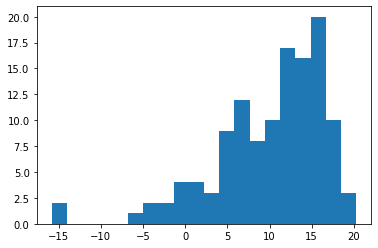

In [7]:
# normality test for all DGR results
norm = sp.stats.normaltest(dall.DGR, axis=0, nan_policy='propagate')
print(norm)
plt.hist(dall['GR'], bins = 20)

[Text(0.5, 0, 'Daily growth rate\n [% per day]')]

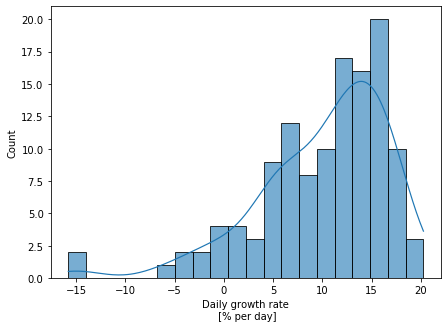

In [8]:
fig,ax = plt.subplots(1,1,figsize=(7,5))#,sharex=True)
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16,"weight":'bold'}) 

ax = sns.histplot(dall['GR'], kde = True,bins = 20,alpha=0.6,legend=True)
#ax.legend(['Beakers', 'Indoor','Offshore','Outdoor MPBR'],fontsize = 12)
ax.set(xlabel= 'Daily growth rate\n [% per day]')

In [9]:
# All internal N results by treatment
dNall = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)]
rp.summary_cont(dNall['N'].groupby(dNall['Treatment']))

,N,Mean,SD,SE,95% Conf.,Interval
Treatment,,,,,,
1000/1/168,33,2.4912,0.6745,0.1174,2.2520,2.7304
200/5/168,9,2.1121,0.4775,0.1592,1.7451,2.4791
2000/1/168,9,3.7062,0.5282,0.1761,3.3002,4.1123
2000/1/4,6,1.8289,0.5519,0.2253,1.2497,2.4080
500/1/4,6,1.4601,0.5363,0.2189,0.8973,2.0229
500/2/168,40,2.5453,0.4467,0.0706,2.4024,2.6881
500/3/168,14,3.3235,0.7194,0.1923,2.9082,3.7389


NormaltestResult(statistic=5.151973738605474, pvalue=0.0760787059999321)


(array([ 3.,  3.,  4.,  2.,  5., 13., 17.,  9.,  6., 10.,  7., 10.,  7.,
         7.,  2.,  4.,  3.,  0.,  3.,  2.]),
 array([1.01343012, 1.1890656 , 1.36470108, 1.54033656, 1.71597204,
        1.89160752, 2.067243  , 2.24287848, 2.41851397, 2.59414945,
        2.76978493, 2.94542041, 3.12105589, 3.29669137, 3.47232685,
        3.64796233, 3.82359781, 3.99923329, 4.17486877, 4.35050426,
        4.52613974]),
 <a list of 20 Patch objects>)

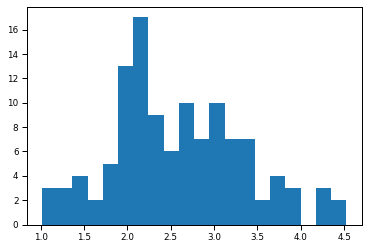

In [10]:
# normality test for all N results
normN = sp.stats.normaltest(dNall.DGR, axis=0, nan_policy='propagate')
print(normN)
plt.hist(dNall['N'], bins = 20)

[Text(0.5, 0, 'Internal N\n [% g N per g DW]')]

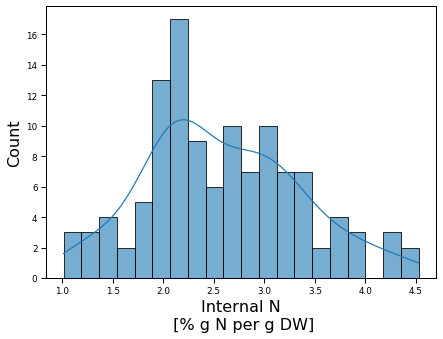

In [11]:
fig,ax = plt.subplots(1,1,figsize=(7,5))#,sharex=True)
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16,"weight":'bold'}) 

ax = sns.histplot(dNall['N'], kde = True,bins = 20,alpha=0.6,legend=True)
#ax.legend(['Beakers', 'Indoor','Offshore','Outdoor MPBR'],fontsize = 12)
ax.set(xlabel= 'Internal N\n [% g N per g DW]')

In [12]:
# All fertilization efficiency results by treatment
dEffall = df2[(df2.Stage == 'f')&(np.isnan(df2.Fertilizing_Efficiency)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)]
rp.summary_cont(dEffall['Fertilizing_Efficiency'].groupby(dEffall['Treatment']))

,N,Mean,SD,SE,95% Conf.,Interval
Treatment,,,,,,
1000/1/168,33,0.3325,0.1845,0.0321,0.2671,0.3979
200/5/168,9,0.2038,0.0877,0.0292,0.1365,0.2712
2000/1/168,9,0.1679,0.1275,0.0425,0.0699,0.2659
2000/1/4,6,0.0003,0.0304,0.0124,-0.0316,0.0322
500/1/4,6,0.0132,0.0769,0.0314,-0.0675,0.0938
500/2/168,40,0.3633,0.1243,0.0197,0.3236,0.4031
500/3/168,14,0.3211,0.1759,0.0470,0.2196,0.4227


NormaltestResult(statistic=27.41851988787881, pvalue=1.1121005495801724e-06)


(array([ 3.,  9.,  5., 10.,  6., 15., 31., 15., 11.,  4.,  2.,  2.,  2.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.08982707, -0.02873871,  0.03234965,  0.09343801,  0.15452637,
         0.21561473,  0.27670309,  0.33779145,  0.3988798 ,  0.45996816,
         0.52105652,  0.58214488,  0.64323324,  0.7043216 ,  0.76540996,
         0.82649832,  0.88758668,  0.94867503,  1.00976339,  1.07085175,
         1.13194011]),
 <a list of 20 Patch objects>)

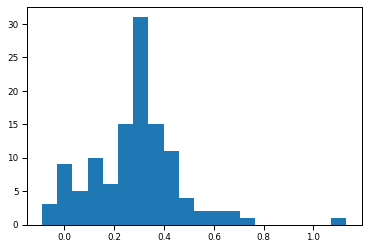

In [13]:
# normality test for all fertilization efficiency results
normEff = sp.stats.normaltest(dEffall.Fertilizing_Efficiency, axis=0, nan_policy='propagate')
print(normEff)
plt.hist(dEffall['Fertilizing_Efficiency'], bins = 20)

In [14]:
# All DGR results by duration 
dall = df2[(df2.Stage == 'f')&(np.isnan(df2.DW)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 2)]
rp.summary_cont(dall['GR'].groupby(dall['Duration']))

,N,Mean,SD,SE,95% Conf.,Interval
Duration,,,,,,
4.0,12,-0.1838,9.1486,2.6410,-5.9965,5.6290
168.0,75,11.4193,5.2248,0.6033,10.2172,12.6214


In [15]:
# All N results by duration 
dNall = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 2)]
rp.summary_cont(dNall['N'].groupby(dNall['Duration']))

,N,Mean,SD,SE,95% Conf.,Interval
Duration,,,,,,
4.0,12,1.6445,0.5534,0.1598,1.2929,1.9961
168.0,70,2.5670,0.7150,0.0855,2.3966,2.7375


In [16]:
# All fertilization efficiency results by duration
dEffall = df2[(df2.Stage == 'f')&(np.isnan(df2.Fertilizing_Efficiency)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 2)]
rp.summary_cont(dEffall['Fertilizing_Efficiency'].groupby(dEffall['Duration']))

,N,Mean,SD,SE,95% Conf.,Interval
Duration,,,,,,
4.0,12,0.0067,0.0561,0.0162,-0.0289,0.0424
168.0,70,0.3058,0.1242,0.0148,0.2762,0.3354


In [17]:
# Mann-Whitney U Test between durations of 4 and 168 hours - GR
stats.mannwhitneyu(dall[(dall.Duration == 4)].GR, dall[(dall.Duration == 168)].GR)

MannwhitneyuResult(statistic=113.0, pvalue=1.717273290605612e-05)

In [18]:
# Mann-Whitney U Test between durations of 4 and 168 hours - N
stats.mannwhitneyu(dNall[(dNall.Duration == 4)].N, dNall[(dNall.Duration == 168)].N)

MannwhitneyuResult(statistic=120.0, pvalue=4.2607052009232235e-05)

In [19]:
# Mann-Whitney U Test between durations of 4 and 168 hours - fertilizing efficiency
stats.mannwhitneyu(dEffall[(dEffall.Duration == 4)].Fertilizing_Efficiency, dEffall[(dEffall.Duration == 168)].Fertilizing_Efficiency)

MannwhitneyuResult(statistic=7.0, pvalue=3.120988629273312e-08)

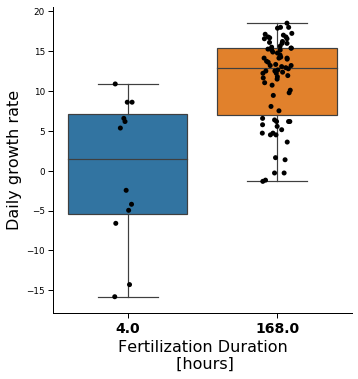

In [20]:
# DGR in different durations - all weeks together
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Duration', y = 'GR', data = dall,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
fig = sns.stripplot(x = 'Duration', y = 'GR', data = dall,color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')

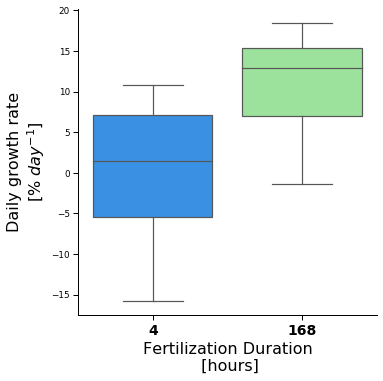

In [21]:
# DGR in different durations - all weeks together - no scatter
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Duration', y = 'GR', data = dall,kind='box',palette=sns.color_palette(['dodgerblue', 'lightgreen'])).set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate\n[% $day^{-1}$]')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Duration', y = 'DGR', data = dall,color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')

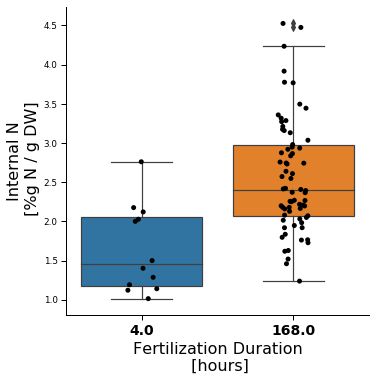

In [22]:
# N in different durations - all weeks together
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Duration', y = 'N', data = dNall,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
fig = sns.stripplot(x = 'Duration', y = 'N', data = dNall,color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Internal N\n [%g N / g DW]')

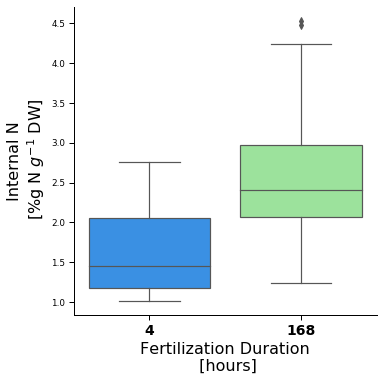

In [23]:
# N in different durations - all weeks together - no scatter
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Duration', y = 'N', data = dNall,kind='box',palette=sns.color_palette(['dodgerblue', 'lightgreen'])).set(xlabel='Fertilization Duration\n [hours]', ylabel='Internal N\n [%g N $g^{-1}$ DW]')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})

#fig = sns.stripplot(x = 'Duration', y = 'N', data = dNall,color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Internal N\n [%g N / g DW]')

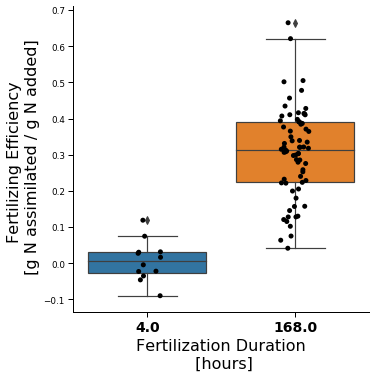

In [24]:
# Fertilization efficiency in different durations - all weeks together
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Duration', y = 'Fertilizing_Efficiency', data = dEffall,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
fig = sns.stripplot(x = 'Duration', y = 'Fertilizing_Efficiency', data = dEffall,color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Fertilizing Efficiency \n [g N assimilated / g N added]')

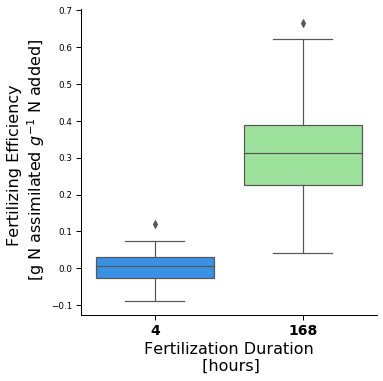

In [25]:
# Fertilization efficiency in different durations - all weeks together - no scatter
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Duration', y = 'Fertilizing_Efficiency', data = dEffall,kind='box',palette=sns.color_palette(['dodgerblue', 'lightgreen'])).set(xlabel='Fertilization Duration\n [hours]', ylabel='Fertilizing Efficiency \n [g N assimilated $g^{-1}$ N added]')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Duration', y = 'Fertilizing_Efficiency', data = dEffall,color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Fertilizing Efficiency \n [g N assimilated / g N added]')

In [26]:
# All DGR results by duration by week
for i in [1,2]:
    print('\nweek: ' + str(i) + '\n')
    print(rp.summary_cont(dall[(dall.Week == i)]['GR'].groupby(dall[(dall.Week == i)]['Duration'])))


week: 1



           N     Mean      SD      SE  95% Conf.  Interval
Duration                                                  
4.0        6   7.6864  2.0423  0.8337     5.5432    9.8296
168.0     39  11.0909  5.5170  0.8834     9.3025   12.8793

week: 2



           N     Mean      SD      SE  95% Conf.  Interval
Duration                                                  
4.0        6  -8.0539  5.5951  2.2842   -13.9257   -2.1822
168.0     36  11.7750  4.9417  0.8236    10.1030   13.4471


In [27]:
# All N results by duration by week
for i in [1,2]:
    print('\nweek: ' + str(i) + '\n')
    print(rp.summary_cont(dNall[(dNall.Week == i)]['N'].groupby(dNall[(dNall.Week == i)]['Duration'])))



week: 1



           N    Mean      SD      SE  95% Conf.  Interval
Duration                                                 
4.0        6  1.2518  0.1802  0.0736     1.0627    1.4409
168.0     35  2.4737  0.7722  0.1305     2.2085    2.7390

week: 2



           N    Mean      SD      SE  95% Conf.  Interval
Duration                                                 
4.0        6  2.0372  0.5208  0.2126     1.4906    2.5837
168.0     35  2.6604  0.6507  0.1100     2.4368    2.8839


In [28]:
# All fertilization efficiency results by duration by week
for i in [1,2]:
    print('\nweek: ' + str(i) + '\n')
    print(rp.summary_cont(dEffall[(dEffall.Week == i)]['Fertilizing_Efficiency'].groupby(dEffall[(dEffall.Week == i)]['Duration'])))


week: 1



           N    Mean      SD      SE  95% Conf.  Interval
Duration                                                 
4.0        6  0.0063  0.0564  0.0230    -0.0528    0.0655
168.0     35  0.2892  0.1143  0.0193     0.2499    0.3285

week: 2



           N    Mean      SD      SE  95% Conf.  Interval
Duration                                                 
4.0        6  0.0071  0.0613  0.0250    -0.0571    0.0714
168.0     35  0.3223  0.1328  0.0225     0.2767    0.3679


In [29]:
# DGR/N/Fertilizing Efficiency in different durations - by week

for i in [1,2]:
    # Mann-Whitney U Test between durations of 4 and 168 hours - DGR
    print('\nWeek ' + str(i) + ':\n')
    a = stats.mannwhitneyu(dall[(dall.Week == i)&(dall.Duration == 4)].DGR, dall[(dall.Week == i)&(dall.Duration == 168)].DGR)
    print('DGR: ')
    print(a)

    # Mann-Whitney U Test between durations of 4 and 168 hours - N
    b = stats.mannwhitneyu(dNall[(dNall.Week == i)&(dNall.Duration == 4)].N, dNall[(dNall.Week == i)&(dNall.Duration == 168)].N)
    print('\nN: ')
    print(b)
       
    # Mann-Whitney U Test between durations of 4 and 168 hours - fertilizing efficiency
    c = stats.mannwhitneyu(dEffall[(dEffall.Week == i)&(dEffall.Duration == 4)].Fertilizing_Efficiency, dEffall[(dEffall.Week == i)&(dEffall.Duration == 168)].Fertilizing_Efficiency)
    print('\nFertilizing Efficiency: ')
    print(c)


Week 1:

DGR: 
MannwhitneyuResult(statistic=62.0, pvalue=0.034393064101062965)

N: 
MannwhitneyuResult(statistic=3.0, pvalue=9.059870183695398e-05)

Fertilizing Efficiency: 
MannwhitneyuResult(statistic=1.0, pvalue=6.736306875519492e-05)

Week 2:

DGR: 
MannwhitneyuResult(statistic=0.0, pvalue=5.5770849973723745e-05)

N: 
MannwhitneyuResult(statistic=47.0, pvalue=0.01696429072414389)

Fertilizing Efficiency: 
MannwhitneyuResult(statistic=1.0, pvalue=6.736306875519492e-05)


In [30]:
# GR/N/Fertilizing Efficiency in different durations - by week

for i in [1,2]:
    # Mann-Whitney U Test between durations of 4 and 168 hours - DGR
    print('\nWeek ' + str(i) + ':\n')
    a = stats.mannwhitneyu(dall[(dall.Week == i)&(dall.Duration == 4)].GR, dall[(dall.Week == i)&(dall.Duration == 168)].GR)
    print('DGR: ')
    print(a)

    # Mann-Whitney U Test between durations of 4 and 168 hours - N
    b = stats.mannwhitneyu(dNall[(dNall.Week == i)&(dNall.Duration == 4)].N, dNall[(dNall.Week == i)&(dNall.Duration == 168)].N)
    print('\nN: ')
    print(b)
       
    # Mann-Whitney U Test between durations of 4 and 168 hours - fertilizing efficiency
    c = stats.mannwhitneyu(dEffall[(dEffall.Week == i)&(dEffall.Duration == 4)].Fertilizing_Efficiency, dEffall[(dEffall.Week == i)&(dEffall.Duration == 168)].Fertilizing_Efficiency)
    print('\nFertilizing Efficiency: ')
    print(c)


Week 1:

DGR: 
MannwhitneyuResult(statistic=65.0, pvalue=0.042722441928738614)

N: 
MannwhitneyuResult(statistic=3.0, pvalue=9.059870183695398e-05)

Fertilizing Efficiency: 
MannwhitneyuResult(statistic=1.0, pvalue=6.736306875519492e-05)

Week 2:

DGR: 
MannwhitneyuResult(statistic=0.0, pvalue=5.555658057338027e-05)

N: 
MannwhitneyuResult(statistic=47.0, pvalue=0.01696429072414389)

Fertilizing Efficiency: 
MannwhitneyuResult(statistic=1.0, pvalue=6.736306875519492e-05)


In [31]:
# DGR/N/Fertilizing Efficiency in different weeks - by duration

for i in [4,168]:
    # Mann-Whitney U Test between durations of 4 and 168 hours - DGR
    print('\nDuration ' + str(i) + ':\n')
    a = stats.mannwhitneyu(dall[(dall.Duration == i)&(dall.Week == 1)].DGR, dall[(dall.Duration == i)&(dall.Week == 2)].DGR)
    print('DGR: ')
    print(a)

    # Mann-Whitney U Test between durations of 4 and 168 hours - N
    b = stats.mannwhitneyu(dNall[(dNall.Duration == i)&(dNall.Week == 1)].N, dNall[(dNall.Duration == i)&(dNall.Week == 2)].N)
    print('\nN: ')
    print(b)
       
    # Mann-Whitney U Test between durations of 4 and 168 hours - fertilizing efficiency
    c = stats.mannwhitneyu(dEffall[(dEffall.Duration == i)&(dEffall.Week == 1)].Fertilizing_Efficiency, dEffall[(dEffall.Duration == i)&(dEffall.Week == 2)].Fertilizing_Efficiency)
    print('\nFertilizing Efficiency: ')
    print(c)


Duration 4:

DGR: 
MannwhitneyuResult(statistic=0.0, pvalue=0.0025374340489701264)

N: 
MannwhitneyuResult(statistic=4.0, pvalue=0.015319493968851633)

Fertilizing Efficiency: 
MannwhitneyuResult(statistic=16.0, pvalue=0.40509061820523684)

Duration 168:

DGR: 
MannwhitneyuResult(statistic=624.0, pvalue=0.20556941046568866)

N: 
MannwhitneyuResult(statistic=477.0, pvalue=0.05640114291434486)

Fertilizing Efficiency: 
MannwhitneyuResult(statistic=528.0, pvalue=0.16190179363864288)


In [32]:
# GR/N/Fertilizing Efficiency in different weeks - by duration

for i in [4,168]:
    # Mann-Whitney U Test between durations of 4 and 168 hours - DGR
    print('\nDuration ' + str(i) + ':\n')
    a = stats.mannwhitneyu(dall[(dall.Duration == i)&(dall.Week == 1)].GR, dall[(dall.Duration == i)&(dall.Week == 2)].GR)
    print('DGR: ')
    print(a)

    # Mann-Whitney U Test between durations of 4 and 168 hours - N
    b = stats.mannwhitneyu(dNall[(dNall.Duration == i)&(dNall.Week == 1)].N, dNall[(dNall.Duration == i)&(dNall.Week == 2)].N)
    print('\nN: ')
    print(b)
       
    # Mann-Whitney U Test between durations of 4 and 168 hours - fertilizing efficiency
    c = stats.mannwhitneyu(dEffall[(dEffall.Duration == i)&(dEffall.Week == 1)].Fertilizing_Efficiency, dEffall[(dEffall.Duration == i)&(dEffall.Week == 2)].Fertilizing_Efficiency)
    print('\nFertilizing Efficiency: ')
    print(c)


Duration 4:

DGR: 
MannwhitneyuResult(statistic=0.0, pvalue=0.002499062382541226)

N: 
MannwhitneyuResult(statistic=4.0, pvalue=0.015319493968851633)

Fertilizing Efficiency: 
MannwhitneyuResult(statistic=16.0, pvalue=0.40509061820523684)

Duration 168:

DGR: 
MannwhitneyuResult(statistic=655.5, pvalue=0.3128146851209107)

N: 
MannwhitneyuResult(statistic=477.0, pvalue=0.05640114291434486)

Fertilizing Efficiency: 
MannwhitneyuResult(statistic=528.0, pvalue=0.16190179363864288)


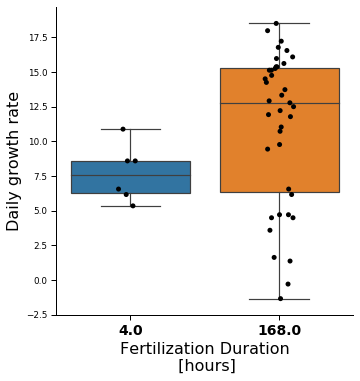

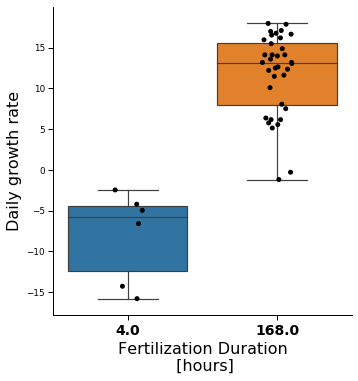

In [33]:
# DGR in different durations - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
for i in [1,2]:
    fig = sns.catplot(x = 'Duration', y = 'GR', data = dall[(dall.Week == i)],kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
    fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
    fig = sns.stripplot(x = 'Duration', y = 'GR', data = dall[(dall.Week == i)],color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')

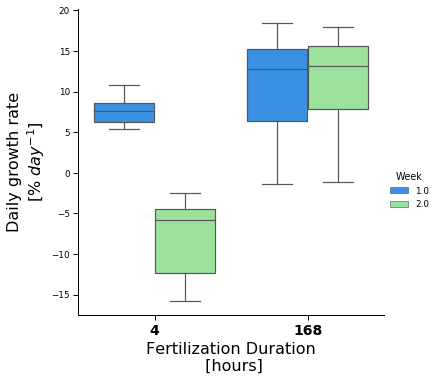

In [34]:
# DGR in different durations - by week - no scatter, one plot
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
#for i in [1,2]:
fig = sns.catplot(x = 'Duration', y = 'GR', data = dall,kind='box',hue='Week',palette=sns.color_palette(['dodgerblue', 'lightgreen'])).set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate\n[% $day^{-1}$]')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Duration', y = 'DGR', data = dall[(dall.Week == i)],color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')

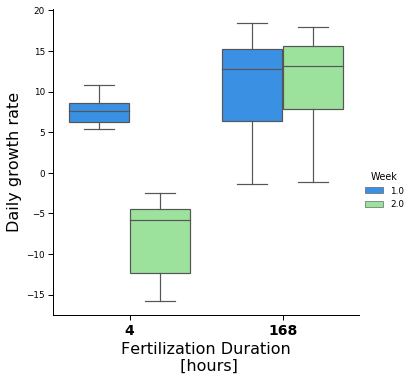

In [35]:
# DGR in different durations - by week - no scatter, one plot
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
#for i in [1,2]:
fig = sns.catplot(x = 'Duration', y = 'GR', data = dall,kind='box',hue='Week',palette=sns.color_palette(['dodgerblue', 'lightgreen'])).set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
    #fig = sns.stripplot(x = 'Duration', y = 'DGR', data = dall[(dall.Week == i)],color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')

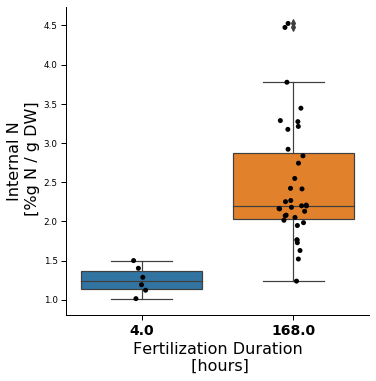

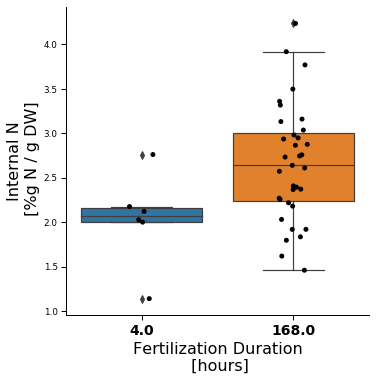

In [36]:
# N in different durations - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
for i in [1,2]:
    fig = sns.catplot(x = 'Duration', y = 'N', data = dNall[(dNall.Week == i)],kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
    fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
    fig = sns.stripplot(x = 'Duration', y = 'N', data = dNall[(dNall.Week == i)],color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Internal N\n [%g N / g DW]')

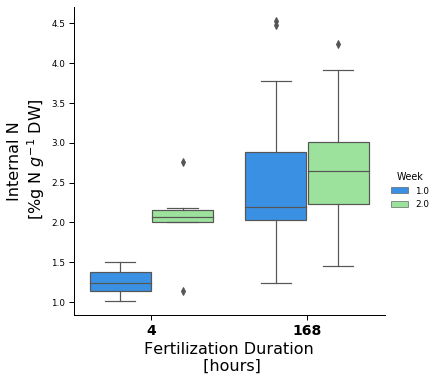

In [37]:
# N in different durations - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
#for i in [1,2]:
fig = sns.catplot(x = 'Duration', y = 'N', data = dNall,kind='box',hue='Week',palette=sns.color_palette(['dodgerblue', 'lightgreen'])).set(xlabel='Fertilization Duration\n [hours]', ylabel='Internal N\n [%g N $g^{-1}$ DW]')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Duration', y = 'N', data = dNall[(dNall.Week == i)],color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Internal N\n [%g N / g DW]')

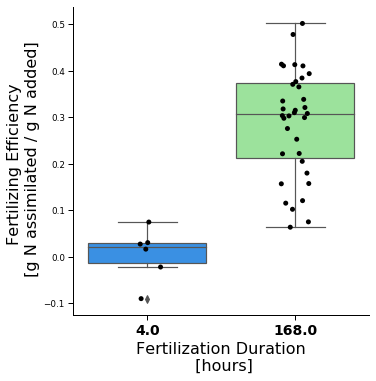

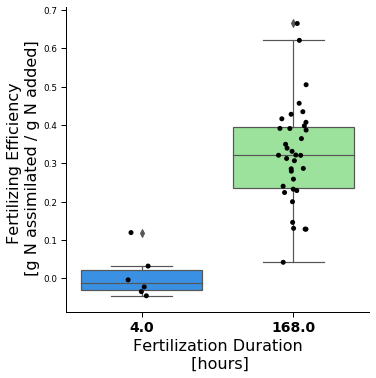

In [38]:
# Fertilizing Efficiency in different durations - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
for i in [1,2]:
    fig = sns.catplot(x = 'Duration', y = 'Fertilizing_Efficiency', data = dEffall[(dEffall.Week == i)],kind='box',palette=sns.color_palette(['dodgerblue', 'lightgreen']))#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
    fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
    fig = sns.stripplot(x = 'Duration', y = 'Fertilizing_Efficiency', data = dEffall[(dEffall.Week == i)],color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Fertilizing Efficiency \n [g N assimilated / g N added]')

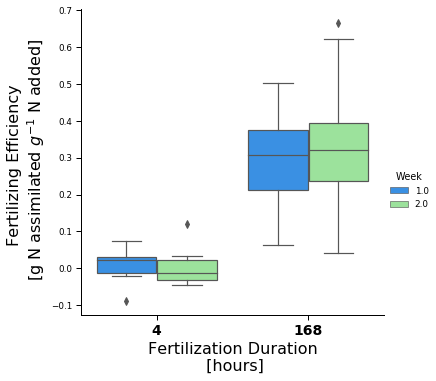

In [39]:
# Fertilizing Efficiency in different durations - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
#for i in [1,2]:
fig = sns.catplot(x = 'Duration', y = 'Fertilizing_Efficiency', data = dEffall,kind='box',hue='Week',palette=sns.color_palette(['dodgerblue', 'lightgreen'])).set(xlabel='Fertilization Duration\n [hours]', ylabel='Fertilizing Efficiency \n [g N assimilated $g^{-1}$ N added]')
fig.set_xticklabels([4, 168],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Duration', y = 'Fertilizing_Efficiency', data = dEffall[(dEffall.Week == i)],color='k').set(xlabel='Fertilization Duration\n [hours]', ylabel='Fertilizing Efficiency \n [g N assimilated / g N added]')

In [40]:
# Weekly total added N
dall = df2[(df2.Stage == 'f')&(np.isnan(df2.DW)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)]
dNall = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)]
dEffall = df2[(df2.Stage == 'f')&(np.isnan(df2.Fertilizing_Efficiency)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)]

In [41]:
# data summary of duration = 168, by flux (DGR)
dall168 = dall[(dall['Duration'] == 168)]
rp.summary_cont(dall168['GR'].groupby(dall168['Flux']))

,N,Mean,SD,SE,95% Conf.,Interval
Flux,,,,,,
1000.0,87,11.3986,5.0440,0.5408,10.3236,12.4736
1500.0,15,11.8421,5.3172,1.3729,8.8975,14.7866
2000.0,9,7.3934,6.0525,2.0175,2.7410,12.0457


In [42]:
# data summary of duration = 168, by flux (N)
dNall168 = dNall[(dNall['Duration'] == 168)]
rp.summary_cont(dNall168['N'].groupby(dNall168['Flux']))

,N,Mean,SD,SE,95% Conf.,Interval
Flux,,,,,,
1000.0,82,2.4760,0.5617,0.0620,2.3526,2.5994
1500.0,14,3.3235,0.7194,0.1923,2.9082,3.7389
2000.0,9,3.7062,0.5282,0.1761,3.3002,4.1123


In [43]:
# data summary of duration = 168, by flux (Fertilizing Efficiency)
dEffall168 = dEffall[(dEffall['Duration'] == 168)]
rp.summary_cont(dEffall168['Fertilizing_Efficiency'].groupby(dEffall168['Flux']))

,N,Mean,SD,SE,95% Conf.,Interval
Flux,,,,,,
1000.0,82,0.3334,0.1548,0.0171,0.2994,0.3674
1500.0,14,0.3211,0.1759,0.0470,0.2196,0.4227
2000.0,9,0.1679,0.1275,0.0425,0.0699,0.2659


In [44]:
# kruskal test - comparing DGR in different fluxes

sp.stats.kruskal(dall168[(dall168['Flux'] == 1000)]['DGR'],
                dall168[(dall168['Flux'] == 1500)]['DGR'],
                dall168[(dall168['Flux'] == 2000)]['DGR'])

# There is a significant difference between fluxes

KruskalResult(statistic=4.188347149590254, pvalue=0.1231719940440456)

In [45]:
# kruskal test - comparing N in different fluxes

sp.stats.kruskal(dNall168[(dNall168['Flux'] == 1000)]['N'],
                dNall168[(dNall168['Flux'] == 1500)]['N'],
                dNall168[(dNall168['Flux'] == 2000)]['N'])

# There is a significant difference between fluxes

KruskalResult(statistic=30.077824840628125, pvalue=2.9422754089941694e-07)

In [46]:
# kruskal test - comparing Fertilizing Efficiencies in different fluxes

sp.stats.kruskal(dEffall168[(dEffall168['Flux'] == 1000)]['Fertilizing_Efficiency'],
                dEffall168[(dEffall168['Flux'] == 1500)]['Fertilizing_Efficiency'],
                dEffall168[(dEffall168['Flux'] == 2000)]['Fertilizing_Efficiency'])

# There is a significant difference between fluxes

KruskalResult(statistic=8.49671342689561, pvalue=0.014287693402815483)

In [47]:
# post - hoc multiple comparisons between fluxes - DGR

data = [dall168[(dall168['Flux'] == 1000)]['DGR'],
                dall168[(dall168['Flux'] == 1500)]['DGR'],
                dall168[(dall168['Flux'] == 2000)]['DGR']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

#results: Significan difference between:
#1000 and 2000

,1,2,3
1,1.000000,1.000000,0.156559
2,1.000000,1.000000,0.177378
3,0.156559,0.177378,1.000000


In [48]:
# post - hoc multiple comparisons between fluxes - N

data = [dNall168[(dNall168['Flux'] == 1000)]['N'],
                dNall168[(dNall168['Flux'] == 1500)]['N'],
                dNall168[(dNall168['Flux'] == 2000)]['N']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

#results: Significan difference between:
#1000 and 1500 and 1000 and 2000

,1,2,3
1,1.000000,0.000351,0.000043
2,0.000351,1.000000,1.000000
3,0.000043,1.000000,1.000000


In [49]:
# post - hoc multiple comparisons between fluxes - Fertilizing Efficiency

data = [dEffall168[(dEffall168['Flux'] == 1000)]['Fertilizing_Efficiency'],
                dEffall168[(dEffall168['Flux'] == 1500)]['Fertilizing_Efficiency'],
                dEffall168[(dEffall168['Flux'] == 2000)]['Fertilizing_Efficiency']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

#results: Significan difference between:
#1000 and 2000

,1,2,3
1,1.000000,1.000000,0.010676
2,1.000000,1.000000,0.089698
3,0.010676,0.089698,1.000000


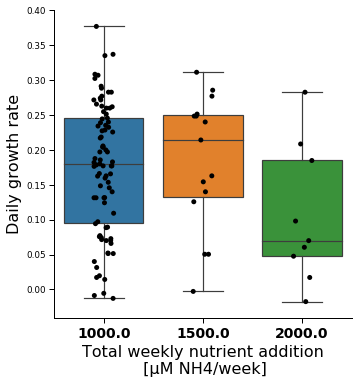

In [50]:
# DGR in different fluxes - all weeks together
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Flux', y = 'DGR', data = dall168,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
fig = sns.stripplot(x = 'Flux', y = 'DGR', data = dall168,color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Daily growth rate')

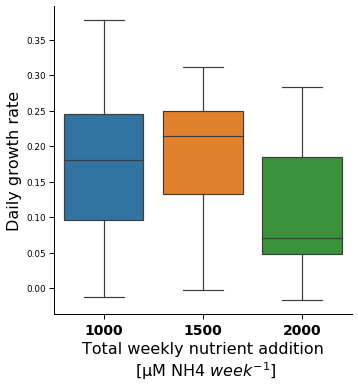

In [51]:
# DGR in different fluxes - all weeks together - without scatter
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Flux', y = 'DGR', data = dall168,kind='box').set(xlabel='Total weekly nutrient addition\n [µM NH4 $week^{-1}$]', ylabel='Daily growth rate')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Flux', y = 'DGR', data = dall168,color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Daily growth rate')

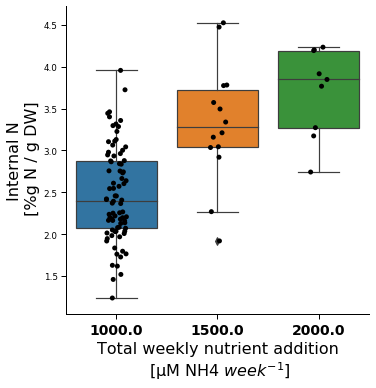

In [52]:
# N in different fluxes - all weeks together
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Flux', y = 'N', data = dNall168,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
fig = sns.stripplot(x = 'Flux', y = 'N', data = dNall168,color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4 $week^{-1}$]', ylabel='Internal N\n [%g N / g DW]')

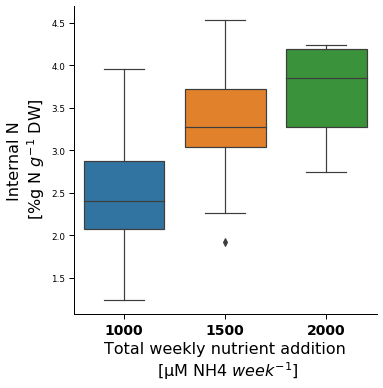

In [53]:
# N in different fluxes - all weeks together - no scatter
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Flux', y = 'N', data = dNall168,kind='box').set(xlabel='Total weekly nutrient addition\n [µM NH4 $week^{-1}$]', ylabel='Internal N\n [%g N $g^{-1}$ DW]')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Flux', y = 'N', data = dNall168,color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Internal N\n [%g N / g DW]')

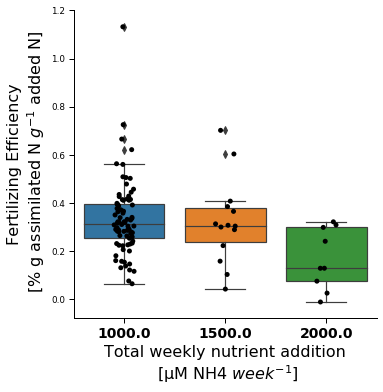

In [54]:
# N in different fluxes - all weeks together
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Flux', y = 'Fertilizing_Efficiency', data = dNall168,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
fig = sns.stripplot(x = 'Flux', y = 'Fertilizing_Efficiency', data = dNall168,color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4 $week^{-1}$]', ylabel='Fertilizing Efficiency\n [% g assimilated N $g^{-1}$ added N]')

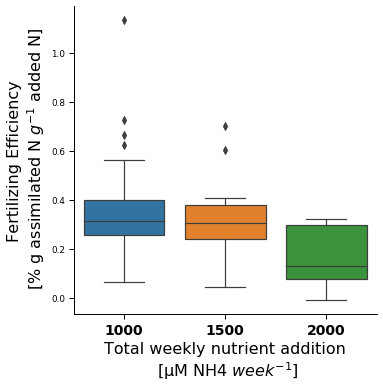

In [55]:
# N in different fluxes - all weeks together - no scatter
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
fig = sns.catplot(x = 'Flux', y = 'Fertilizing_Efficiency', data = dNall168,kind='box').set(xlabel='Total weekly nutrient addition\n [µM NH4 $week^{-1}$]', ylabel='Fertilizing Efficiency\n [% g assimilated N $g^{-1}$ added N]')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Flux', y = 'Fertilizing_Efficiency', data = dNall168,color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Fertilizing Efficiency\n [% g assimilated N / g added N]')

In [56]:
# kruskal test - comparing DGR in different fluxes - different weeks
for i in [1,2,3]:
    s = sp.stats.kruskal(dall168[(dall168['Week'] == i)&(dall168['Flux'] == 1000)]['DGR'],
                    dall168[(dall168['Week'] == i)&(dall168['Flux'] == 1500)]['DGR'],
                    dall168[(dall168['Week'] == i)&(dall168['Flux'] == 2000)]['DGR'])
    print('\nWeek ' + str(i) + ':')
    print(s)
# There is a significant difference between fluxes in all weeks


Week 1:
KruskalResult(statistic=6.365093277773799, pvalue=0.0414798862094787)

Week 2:
KruskalResult(statistic=8.077198627198626, pvalue=0.017622138226422588)

Week 3:
KruskalResult(statistic=8.70123063387838, pvalue=0.01289887324292309)


In [57]:
# post - hoc multiple comparisons between fluxes - DGR, per week
for i in [1,2,3]:
    print('\nWeek: ' + str(i))
    data = [dall168[(dall168['Flux'] == 1000)&(dall168['Week'] == i)]['DGR'],
                    dall168[(dall168['Flux'] == 1500)&(dall168['Week'] == i)]['DGR'],
                    dall168[(dall168['Flux'] == 2000)&(dall168['Week'] == i)]['DGR']]

    s = scp.posthoc_dunn(data, p_adjust = 'bonferroni')
    print(s)
#results: Significan difference between:
#1000 and 2000


Week: 1
          1         2         3
1  1.000000  0.065698  1.000000
2  0.065698  1.000000  0.090031
3  1.000000  0.090031  1.000000

Week: 2
         1         2         3
1  1.00000  0.140730  0.227040
2  0.14073  1.000000  0.015394
3  0.22704  0.015394  1.000000

Week: 3
          1         2         3
1  1.000000  0.758874  0.031328
2  0.758874  1.000000  0.011550
3  0.031328  0.011550  1.000000


In [58]:
# post - hoc multiple comparisons between weeks - DGR, per flux
for i in [1000,1500,2000]:
    print('\nFlux: ' + str(i))
    data = [dall168[(dall168['Week'] == 1)&(dall168['Flux'] == i)]['DGR'],
                    dall168[(dall168['Week'] == 2)&(dall168['Flux'] == i)]['DGR'],
                    dall168[(dall168['Week'] == 3)&(dall168['Flux'] == i)]['DGR']]

    s = scp.posthoc_dunn(data, p_adjust = 'bonferroni')
    print(s)
#results: Significan difference between:
#1000 and 2000


Flux: 1000
     1    2    3
1  1.0  1.0  1.0
2  1.0  1.0  1.0
3  1.0  1.0  1.0

Flux: 1500
          1         2         3
1  1.000000  0.012357  0.076969
2  0.012357  1.000000  1.000000
3  0.076969  1.000000  1.000000

Flux: 2000
          1         2         3
1  1.000000  0.539137  0.021871
2  0.539137  1.000000  0.539137
3  0.021871  0.539137  1.000000


In [59]:
# post - hoc multiple comparisons between weeks - DGR, per flux
#for i in [1000,1500,2000]:
#    print('\nFlux: ' + str(i))
data = [dall168[(dall168['Week'] == 1)&(dall168['Flux'] == 1000)]['DGR'],
                dall168[(dall168['Week'] == 2)&(dall168['Flux'] == 1000)]['DGR'],
                dall168[(dall168['Week'] == 3)&(dall168['Flux'] == 1000)]['DGR'],
                dall168[(dall168['Week'] == 1)&(dall168['Flux'] == 1500)]['DGR'],
                dall168[(dall168['Week'] == 2)&(dall168['Flux'] == 1500)]['DGR'],
                dall168[(dall168['Week'] == 3)&(dall168['Flux'] == 1500)]['DGR'],
                dall168[(dall168['Week'] == 1)&(dall168['Flux'] == 2000)]['DGR'],
                dall168[(dall168['Week'] == 2)&(dall168['Flux'] == 2000)]['DGR'],
                dall168[(dall168['Week'] == 3)&(dall168['Flux'] == 2000)]['DGR']]

s = scp.posthoc_dunn(data, p_adjust = 'bonferroni')
print(s)
#results: Significan difference between:
#1000 and 2000

          1         2         3         4         5         6         7  \
1  1.000000  1.000000  1.000000  0.730098  1.000000  1.000000  1.000000   
2  1.000000  1.000000  1.000000  0.578450  1.000000  1.000000  1.000000   
3  1.000000  1.000000  1.000000  1.000000  0.786344  1.000000  1.000000   
4  0.730098  0.578450  1.000000  1.000000  0.037810  0.571017  0.813074   
5  1.000000  1.000000  0.786344  0.037810  1.000000  1.000000  1.000000   
6  1.000000  1.000000  1.000000  0.571017  1.000000  1.000000  1.000000   
7  1.000000  1.000000  1.000000  0.813074  1.000000  1.000000  1.000000   
8  1.000000  1.000000  1.000000  1.000000  0.185113  1.000000  1.000000   
9  0.289805  0.234943  0.631975  1.000000  0.016751  0.213758  0.305595   

          8         9  
1  1.000000  0.289805  
2  1.000000  0.234943  
3  1.000000  0.631975  
4  1.000000  1.000000  
5  0.185113  0.016751  
6  1.000000  0.213758  
7  1.000000  0.305595  
8  1.000000  1.000000  
9  1.000000  1.000000  


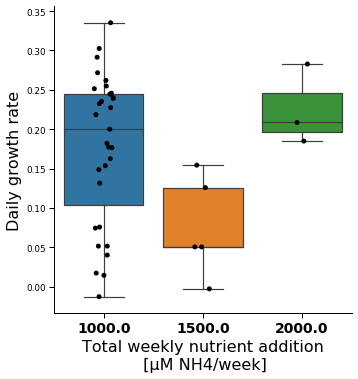

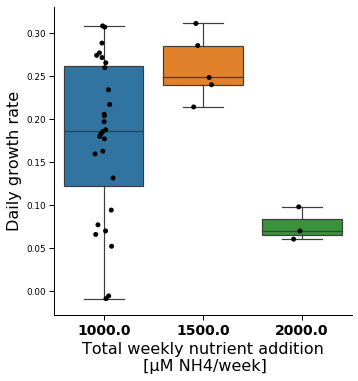

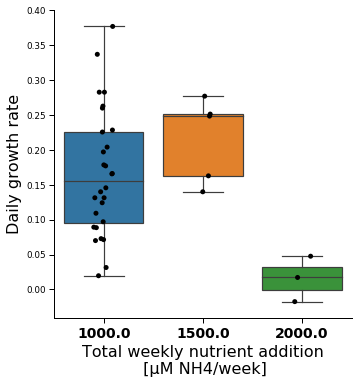

In [60]:
# DGR in different fluxes - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

for i in [1,2,3]:
    fig = sns.catplot(x = 'Flux', y = 'DGR', data = dall168[(dall168.Week == i)],kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
    fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
    fig = sns.stripplot(x = 'Flux', y = 'DGR', data = dall168[(dall168.Week == i)],color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Daily growth rate')

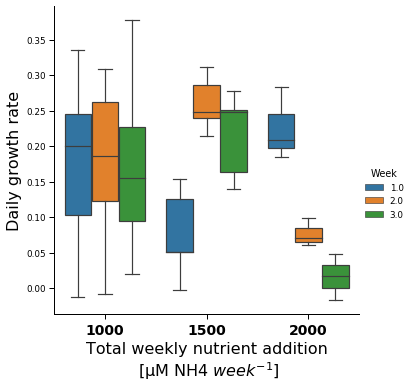

In [61]:
# DGR in different fluxes - by week - no scatter, one plot
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

#for i in [1,2,3]:
fig = sns.catplot(x = 'Flux', y = 'DGR', data = dall168,hue='Week',kind='box').set(xlabel='Total weekly nutrient addition\n [µM NH4 $week^{-1}$]', ylabel='Daily growth rate')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Flux', y = 'DGR', data = dall168[(dall168.Week == i)],color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Daily growth rate')

In [62]:
# kruskal test - comparing N in different fluxes - different weeks
for i in [1,2,3]:
    s = sp.stats.kruskal(dNall168[(dNall168['Week'] == i)&(dNall168['Flux'] == 1000)]['N'],
                    dNall168[(dNall168['Week'] == i)&(dNall168['Flux'] == 1500)]['N'],
                    dNall168[(dNall168['Week'] == i)&(dNall168['Flux'] == 2000)]['N'])
    print('\nWeek ' + str(i) + ':')
    print(s)
# There is a significant difference between fluxes in all weeks


Week 1:
KruskalResult(statistic=14.796331569664915, pvalue=0.0006123749590768649)

Week 2:
KruskalResult(statistic=9.142857142857153, pvalue=0.010343173196618195)

Week 3:
KruskalResult(statistic=11.996712018140599, pvalue=0.002482830574267546)


In [63]:
# post - hoc multiple comparisons between fluxes - N, per week
for i in [1,2,3]:
    print('\nWeek: ' + str(i))
    data = [dNall168[(dNall168['Flux'] == 1000)&(dNall168['Week'] == i)]['N'],
                    dNall168[(dNall168['Flux'] == 1500)&(dNall168['Week'] == i)]['N'],
                    dNall168[(dNall168['Flux'] == 2000)&(dNall168['Week'] == i)]['N']]

    s = scp.posthoc_dunn(data, p_adjust = 'bonferroni')
    print(s)
    
#results: Significan difference between:
#1000 and 2000


Week: 1
          1         2         3
1  1.000000  0.001706  0.100457
2  0.001706  1.000000  1.000000
3  0.100457  1.000000  1.000000

Week: 2
          1         2         3
1  1.000000  0.855148  0.009850
2  0.855148  1.000000  0.247057
3  0.009850  0.247057  1.000000

Week: 3
          1         2         3
1  1.000000  0.112565  0.008606
2  0.112565  1.000000  1.000000
3  0.008606  1.000000  1.000000


In [64]:
# post - hoc multiple comparisons between weeks - DGR, per flux
for i in [1000,1500,2000]:
    print('\nFlux: ' + str(i))
    data = [dNall168[(dNall168['Week'] == 1)&(dNall168['Flux'] == i)]['N'],
                    dNall168[(dNall168['Week'] == 2)&(dNall168['Flux'] == i)]['N'],
                    dNall168[(dNall168['Week'] == 3)&(dNall168['Flux'] == i)]['N']]

    s = scp.posthoc_dunn(data, p_adjust = 'bonferroni')
    print(s)
#results: Significan difference between:
#1000 and 2000


Flux: 1000
          1         2         3
1  1.000000  0.053170  0.000411
2  0.053170  1.000000  0.466072
3  0.000411  0.466072  1.000000

Flux: 1500
          1         2         3
1  1.000000  0.148099  1.000000
2  0.148099  1.000000  0.363342
3  1.000000  0.363342  1.000000

Flux: 2000
          1         2         3
1  1.000000  0.157897  0.110665
2  0.157897  1.000000  1.000000
3  0.110665  1.000000  1.000000


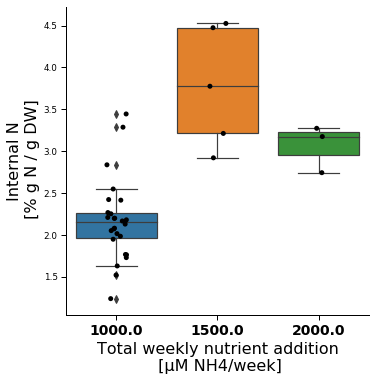

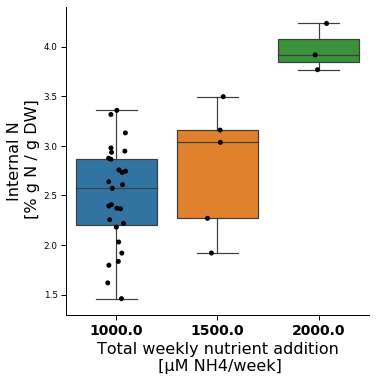

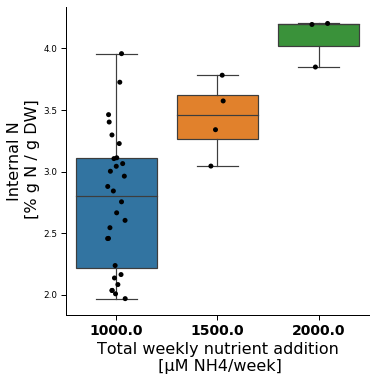

In [65]:
# N in different fluxes - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

for i in [1,2,3]:
    fig = sns.catplot(x = 'Flux', y = 'N', data = dNall168[(dNall168.Week == i)],kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
    fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
    fig = sns.stripplot(x = 'Flux', y = 'N', data = dNall168[(dNall168.Week == i)],color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Internal N\n [% g N / g DW]')

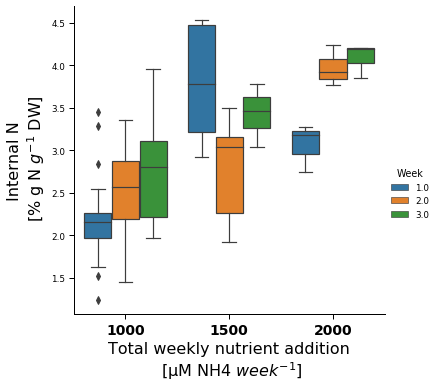

In [66]:
# N in different fluxes - by week - one plot, no scatter
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

#for i in [1,2,3]:
fig = sns.catplot(x = 'Flux', y = 'N', data = dNall168,hue='Week',kind='box').set(xlabel='Total weekly nutrient addition\n [µM NH4 $week^{-1}$]', ylabel='Internal N\n [% g N $g^{-1}$ DW]')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Flux', y = 'N', data = dNall168[(dNall168.Week == i)],color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Internal N\n [% g N / g DW]')

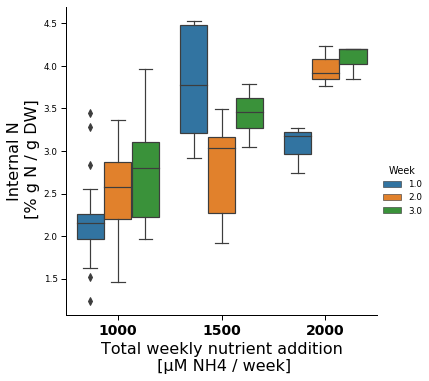

In [67]:
# N in different fluxes - by week, no scatter, one plot
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

#for i in [1,2,3]:
fig = sns.catplot(x = 'Flux', y = 'N', data = dNall168,hue='Week',kind='box').set(xlabel='Total weekly nutrient addition\n [µM NH4 / week]', ylabel='Internal N\n [% g N / g DW]')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Flux', y = 'N', data = dNall168[(dNall168.Week == i)],color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Internal N\n [% g N / g DW]')

In [68]:
# kruskal test - comparing Fertilizing Efficiencies in different fluxes - different weeks
for i in [1,2,3]:
    s = sp.stats.kruskal(dEffall168[(dEffall168['Week'] == i)&(dEffall168['Flux'] == 1000)]['Fertilizing_Efficiency'],
                    dEffall168[(dEffall168['Week'] == i)&(dEffall168['Flux'] == 1500)]['Fertilizing_Efficiency'],
                    dEffall168[(dEffall168['Week'] == i)&(dEffall168['Flux'] == 2000)]['Fertilizing_Efficiency'])
    print('\nWeek ' + str(i) + ':')
    print(s)
# There is a significant difference between fluxes in all weeks


Week 1:
KruskalResult(statistic=1.526067019400358, pvalue=0.4662499059685431)

Week 2:
KruskalResult(statistic=5.668289241622574, pvalue=0.058768773926385014)

Week 3:
KruskalResult(statistic=9.839455782312939, pvalue=0.00730111727509218)


In [69]:
# post - hoc multiple comparisons between fluxes - Fertilizing Efficiency
for i in [1,2,3]:
    print('\nWeek: ' + str(i))
    data = [dEffall168[(dEffall168['Flux'] == 1000)&(dEffall168['Week'] == i)]['Fertilizing_Efficiency'],
                    dEffall168[(dEffall168['Flux'] == 1500)&(dEffall168['Week'] == i)]['Fertilizing_Efficiency'],
                    dEffall168[(dEffall168['Flux'] == 2000)&(dEffall168['Week'] == i)]['Fertilizing_Efficiency']]

    s = scp.posthoc_dunn(data, p_adjust = 'bonferroni')
    print(s)
#results: Significan difference between:
#1000 and 2000


Week: 1
          1         2    3
1  1.000000  0.650111  1.0
2  0.650111  1.000000  1.0
3  1.000000  1.000000  1.0

Week: 2
          1         2         3
1  1.000000  1.000000  0.055145
2  1.000000  1.000000  0.363342
3  0.055145  0.363342  1.000000

Week: 3
          1         2         3
1  1.000000  0.525044  0.023297
2  0.525044  1.000000  0.006495
3  0.023297  0.006495  1.000000


In [70]:
# post - hoc multiple comparisons between weeks - DGR, per flux
for i in [1000,1500,2000]:
    print('\nFlux: ' + str(i))
    data = [dEffall168[(dEffall168['Week'] == 1)&(dEffall168['Flux'] == i)]['Fertilizing_Efficiency'],
                    dEffall168[(dEffall168['Week'] == 2)&(dEffall168['Flux'] == i)]['Fertilizing_Efficiency'],
                    dEffall168[(dEffall168['Week'] == 3)&(dEffall168['Flux'] == i)]['Fertilizing_Efficiency']]

    s = scp.posthoc_dunn(data, p_adjust = 'bonferroni')
    print(s)
#results: Significan difference between:
#1000 and 2000


Flux: 1000
          1         2    3
1  1.000000  0.879233  1.0
2  0.879233  1.000000  1.0
3  1.000000  1.000000  1.0

Flux: 1500
          1         2         3
1  1.000000  0.869755  0.314805
2  0.869755  1.000000  1.000000
3  0.314805  1.000000  1.000000

Flux: 2000
          1         2         3
1  1.000000  0.539137  0.021871
2  0.539137  1.000000  0.539137
3  0.021871  0.539137  1.000000


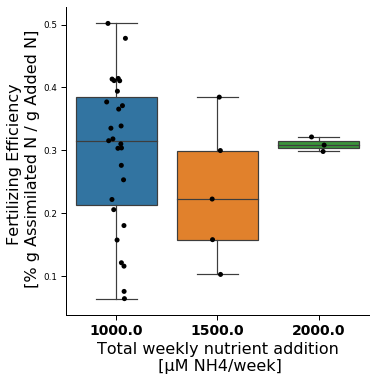

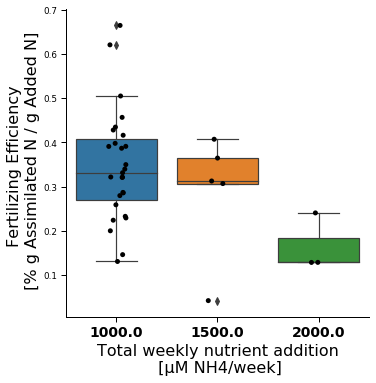

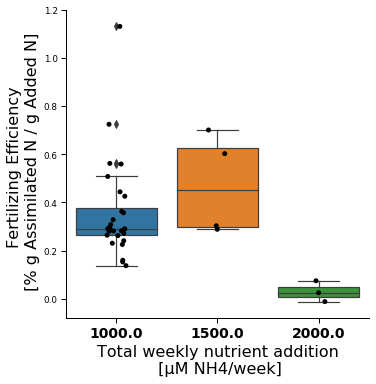

In [71]:
# N in different fluxes - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

for i in [1,2,3]:
    fig = sns.catplot(x = 'Flux', y = 'Fertilizing_Efficiency', data = dEffall168[(dEffall168.Week == i)],kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
    fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
    fig = sns.stripplot(x = 'Flux', y = 'Fertilizing_Efficiency', data = dEffall168[(dEffall168.Week == i)],color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Fertilizing Efficiency \n [% g Assimilated N / g Added N]')

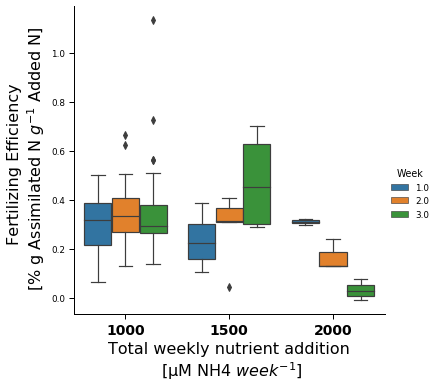

In [72]:
# N in different fluxes - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

#for i in [1,2,3]:
fig = sns.catplot(x = 'Flux', y = 'Fertilizing_Efficiency', data = dEffall168,hue='Week',kind='box').set(xlabel='Total weekly nutrient addition\n [µM NH4 $week^{-1}$]', ylabel='Fertilizing Efficiency \n [% g Assimilated N $g^{-1}$ Added N]')
fig.set_xticklabels([1000, 1500, 2000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Flux', y = 'Fertilizing_Efficiency', data = dEffall168[(dEffall168.Week == i)],color='k').set(xlabel='Total weekly nutrient addition\n [µM NH4/week]', ylabel='Fertilizing Efficiency \n [% g Assimilated N / g Added N]')

In [ ]:
# Effects of amplitudes (treatments)

In [ ]:
# data summary of flux = 1000, by treatment (DGR)
dall1000 = dall[(dall['Duration'] == 168)&(dall['Flux'] == 1000)]
print(rp.summary_cont(dall1000['DGR'].groupby(dall1000['Amplitude'])))

# data summary of flux = 1000, by flux (N)
dNall1000 = dNall[(dNall['Duration'] == 168)&(dNall['Flux'] == 1000)]
print(rp.summary_cont(dNall1000['N'].groupby(dNall1000['Amplitude'])))

# data summary of duration = 168, by flux (Fertilizing Efficiency)
dEffall1000 = dEffall[(dEffall['Duration'] == 168)&(dEffall['Flux'] == 1000)]
print(rp.summary_cont(dEffall1000['Fertilizing_Efficiency'].groupby(dEffall1000['Amplitude'])))

In [ ]:
# kruskal test - comparing N in different amplitudes
print('\nDGR: ')
print(sp.stats.kruskal(dall1000[(dall1000['Amplitude'] == 1000)]['DGR'],
                dall1000[(dall1000['Amplitude'] == 500)]['DGR'],
                dall1000[(dall1000['Amplitude'] == 200)]['DGR']))

print('\nN: ')
print(sp.stats.kruskal(dNall1000[(dNall1000['Amplitude'] == 1000)]['N'],
                dNall1000[(dNall1000['Amplitude'] == 500)]['N'],
                dNall1000[(dNall1000['Amplitude'] == 200)]['N']))

print('\nFertilizing Efficiency: ')
print(sp.stats.kruskal(dEffall1000[(dEffall1000['Amplitude'] == 1000)]['Fertilizing_Efficiency'],
                dEffall1000[(dEffall1000['Amplitude'] == 500)]['Fertilizing_Efficiency'],
                dEffall1000[(dEffall1000['Amplitude'] == 200)]['Fertilizing_Efficiency']))


In [ ]:
# post - hoc multiple comparisons between treatments
print('\nDGR: ')
data = [dall1000[(dall1000['Amplitude'] == 1000)]['DGR'],
                dall1000[(dall1000['Amplitude'] == 500)]['DGR'],
                dall1000[(dall1000['Amplitude'] == 200)]['DGR']]

print(scp.posthoc_dunn(data, p_adjust = 'bonferroni'))

print('\nN: ')
data = [dNall1000[(dNall1000['Amplitude'] == 1000)]['N'],
                dNall1000[(dNall1000['Amplitude'] == 500)]['N'],
                dNall1000[(dNall1000['Amplitude'] == 200)]['N']]

print(scp.posthoc_dunn(data, p_adjust = 'bonferroni'))

print('\nFertilizing Efficiency: ')
data = [dEffall1000[(dEffall1000['Amplitude'] == 1000)]['Fertilizing_Efficiency'],
                dEffall1000[(dEffall1000['Amplitude'] == 500)]['Fertilizing_Efficiency'],
                dEffall1000[(dEffall1000['Amplitude'] == 200)]['Fertilizing_Efficiency']]

print(scp.posthoc_dunn(data, p_adjust = 'bonferroni'))

In [ ]:
# Exp #5

# data summary of flux = 1000, by treatment (DGR)
dall1000_5 = dall[(dall['Duration'] == 168)&(dall['Flux'] == 1000)&(dall['Exp'] == 5)]
print(rp.summary_cont(dall1000_5['DGR'].groupby(dall1000_5['Treatment'])))

# data summary of flux = 1000, by flux (N)
dNall1000_5= dNall[(dNall['Duration'] == 168)&(dNall['Flux'] == 1000)&(dNall['Exp'] == 5)]
print(rp.summary_cont(dNall1000_5['N'].groupby(dNall1000_5['Treatment'])))

# data summary of duration = 168, by flux (Fertilizing Efficiency)
dEffall1000_5 = dEffall[(dEffall['Duration'] == 168)&(dEffall['Flux'] == 1000)&(dEffall['Exp'] == 5)]
print(rp.summary_cont(dEffall1000_5['Fertilizing_Efficiency'].groupby(dEffall1000_5['Treatment'])))

In [ ]:
# post - hoc multiple comparisons between treatments - DGR - exp #5
data = [dall1000_5[(dall1000_5['Amplitude'] == 1000)]['DGR'],
                dall1000_5[(dall1000_5['Amplitude'] == 500)]['DGR'],
                dall1000_5[(dall1000_5['Amplitude'] == 200)]['DGR']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

In [ ]:
# DGR in different amplitudes -  exp 5 in red
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

fig = sns.catplot(x = 'Amplitude', y = 'DGR', data = dall1000,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([200, 500, 1000],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Amplitude', y = 'DGR', data = dall1000,color = 'k').set(xlabel='Amplitude\n [µM NH4]', ylabel='Daily growth rate')
colors = ['r','k','k']
for i in [1,2,3]:
    fig = sns.stripplot(x = 'Amplitude', y = 'DGR', data = dall1000[(dall1000.Exp == 5)&(dall1000.Week == i)],color = colors[i-1]).set(xlabel='Amplitude\n [µM NH4]', ylabel='Daily growth rate')

In [ ]:
# N in different amplitudes -  exp 5 in red
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

fig = sns.catplot(x = 'Amplitude', y = 'N', data = dNall1000,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([1000, 500, 200],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Amplitude', y = 'N', data = dNall1000,color = 'k').set(xlabel='Amplitude\n [µM NH4]', ylabel='Daily growth rate')
colors = ['r','k','k']
for i in [1,2,3]:
    fig = sns.stripplot(x = 'Amplitude', y = 'N', data = dNall1000[(dNall1000.Exp == 5)&(dNall1000.Week == i)],color = colors[i-1]).set(xlabel='Amplitude\n [µM NH4]', ylabel='Internal N\n[% g N $g^{-1}$ DW]')

In [ ]:
# N in different amplitudes -  exp 5 in red
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

fig = sns.catplot(x = 'Amplitude', y = 'Fertilizing_Efficiency', data = dEffall1000,kind='box')#.set(xlabel='Fertilization Duration\n [hours]', ylabel='Daily growth rate')
fig.set_xticklabels([1000, 500, 200],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#fig = sns.stripplot(x = 'Amplitude', y = 'N', data = dNall1000,color = 'k').set(xlabel='Amplitude\n [µM NH4]', ylabel='Daily growth rate')
colors = ['r','k','k']
for i in [1,2,3]:
    fig = sns.stripplot(x = 'Amplitude', y = 'Fertilizing_Efficiency', data = dEffall1000[(dNall1000.Exp == 5)&(dNall1000.Week == i)],color = colors[i-1]).set(xlabel='Amplitude\n [µM NH4]', ylabel='Fertilizing Efficiency\n[% g N Assimilated $g^{-1}$ N Added]')

In [ ]:
# Exp #5

In [ ]:
# kruskal test - comparing N in different treatments

sp.stats.kruskal(dall1000_5[(dall1000_5['Amplitude'] == 1000)]['DGR'],
                dall1000_5[(dall1000_5['Amplitude'] == 500)]['DGR'],
                dall1000_5[(dall1000_5['Amplitude'] == 200)]['DGR'])

# There is a significant difference between fluxes

In [ ]:
# post - hoc multiple comparisons between treatments - DGR
data = [dall1000_5[(dall1000_5['Amplitude'] == 1000)]['DGR'],
                dall1000_5[(dall1000_5['Amplitude'] == 500)]['DGR'],
                dall1000_5[(dall1000_5['Amplitude'] == 200)]['DGR']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

In [ ]:
# post - hoc multiple comparisons between treatments - N
data = [dNall1000_5[(dNall1000_5['Amplitude'] == 1000)]['N'],
                dNall1000_5[(dNall1000_5['Amplitude'] == 500)]['N'],
                dNall1000_5[(dNall1000_5['Amplitude'] == 200)]['N']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

In [ ]:
# Pearson DGR week 1

from scipy.stats import pearsonr 
   
list1 = [200,500,1000] 
list2 = [0.6,10.3,22.3] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('Pearsons correlation: %.3f' % corr) 
  
# This code is contributed by Amiya Rout 

In [ ]:
# kruskal test - comparing N in different treatments

sp.stats.kruskal(dNall1000_5[(dNall1000_5['Amplitude'] == 1000)]['N'],
                dNall1000_5[(dNall1000_5['Amplitude'] == 500)]['N'],
                dNall1000_5[(dNall1000_5['Amplitude'] == 200)]['N'])

# There is a significant difference between fluxes

In [ ]:
# post - hoc multiple comparisons between treatments - N
data = [dNall1000_5[(dNall1000_5['Amplitude'] == 1000)]['N'],
                dNall1000_5[(dNall1000_5['Amplitude'] == 500)]['N'],
                dNall1000_5[(dNall1000_5['Amplitude'] == 200)]['N']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

#results: Significan difference between:
#1000 and 2000

In [ ]:
# kruskal test - comparing Fertilizing Efficiencies in different treatments

sp.stats.kruskal(dEffall1000_5[(dEffall1000_5['Amplitude'] == 1000)]['Fertilizing_Efficiency'],
                dEffall1000_5[(dEffall1000_5['Amplitude'] == 500)]['Fertilizing_Efficiency'],
                dEffall1000_5[(dEffall1000_5['Amplitude'] == 200)]['Fertilizing_Efficiency'])

# There is a significant difference between fluxes

In [ ]:
# post - hoc multiple comparisons between treatments - Fertilizing Efficiency
data = [dEffall1000_5[(dEffall1000_5['Amplitude'] == 1000)]['Fertilizing_Efficiency'],
                dEffall1000_5[(dEffall1000_5['Amplitude'] == 500)]['Fertilizing_Efficiency'],
                dEffall1000_5[(dEffall1000_5['Amplitude'] == 200)]['Fertilizing_Efficiency']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

#results: Significan difference between:
#1000 and 2000

In [ ]:
# normality test for all N results

In [ ]:
# normality test for all fertilization efficiency results

In [ ]:
# For model - calibration, validation and excluded data

In [ ]:
dd = df2[(df2.Stage != 'i')&(np.isnan(df2.DW)!= True)&(df2.Treatment != 'Acclimation')&(df2.Sporulated != 'Yes')&(df2.Exp != 1)&(df2.Exp != 2)&(df2.Exp != 5)&(df2.Comment != 'Exclude')&(df2.Week <= 3)]
rp.summary_cont(dd['DW'].groupby(dd['Treatment']))

In [ ]:
ddval = df2[(df2.Stage != 'i')&(np.isnan(df2.DW)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)&(df2.Treatment != '2000/1/4')&(df2.Treatment != '500/1/4')&(df2.Exp != 3)&(df2.Exp != 4)]
rp.summary_cont(ddval['N'].groupby(ddval['Treatment']))
rp.summary_cont(ddval['DW'].groupby(ddval['Treatment']))

In [ ]:
ddexc = df2[(df2.Stage != 'i')&(np.isnan(df2.DW)!= True)&(df2.Treatment != 'Acclimation')&(df2.Sporulated == 'Yes')&(df2.Week <= 3)&(df2.Treatment != '2000/1/4')&(df2.Treatment != '500/1/4')]
rp.summary_cont(ddexc['N'].groupby(ddexc['Treatment']))
rp.summary_cont(ddexc['DW'].groupby(ddexc['Treatment']))

In [ ]:
ddN = df2[(df2.Stage != 'i')&(np.isnan(df2.N)!= True)&(df2.Treatment != 'Acclimation')&(df2.Exp != 1)&(df2.Exp != 2)&(df2.Exp != 5)&(df2.Comment != 'Exclude')&(df2.Week <= 3)]
rp.summary_cont(ddN['N'].groupby(ddN['Treatment']))

In [ ]:
ddNval = df2[(df2.Stage != 'i')&(np.isnan(df2.N)!= True)&(df2.Treatment != 'Acclimation')&(df2.Comment != 'Exclude')&(df2.Week <= 3)&(df2.Treatment != '2000/1/4')&(df2.Treatment != '500/1/4')&(df2.Exp != 3)&(df2.Exp != 4)]
rp.summary_cont(ddNval['N'].groupby(ddNval['Treatment']))

In [ ]:
# Statistical analysis for indoor experiments results
# 1. Check normal distribution of DGR in 500/2/168 treatment
# 2. ANOVA / Multiple T-test 2-side unequal...
# a. Effect of Date, frequency and concentration (and also weighing and trimming) on DGR/Nint (all data combined)
# b. Effect of Date, frequency and concentration (and also weighing and trimming) on DGR/Nint (data divided by week)


In [ ]:
# kruskal test - diffrences between exp
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]


dd = d[(d['Treatment'] == '500/2/168')]

#dd = dd[(dd['Week'] == i)]
pDGR = sp.stats.kruskal(dd[(dd['Exp'] == 2)]['DGR'],
                        dd[(dd['Exp'] == 3)]['DGR'],
                        dd[(dd['Exp'] == 4)]['DGR'],
                        dd[(dd['Exp'] == 5)]['DGR'])


#print(len(d168[(d168['Flux'] == 1500)].DGR))
print(pDGR)
# There is a significant difference between frequencies

In [ ]:
# kruskal test - diffrences between exp
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]


dd = d[(d['Treatment'] == '1000/1/168')]

#dd = dd[(dd['Week'] == i)]
pDGR = sp.stats.kruskal(dd[(dd['Exp'] == 1)]['DGR'],
                        dd[(dd['Exp'] == 2)]['DGR'],
                        dd[(dd['Exp'] == 4)]['DGR'],
                        dd[(dd['Exp'] == 5)]['DGR'])


#print(len(d168[(d168['Flux'] == 1500)].DGR))
print(pDGR)
# There is a significant difference between frequencies

In [ ]:
# kruskal test - diffrences between exp
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]


ddN = dN[(dN['Treatment'] == '500/2/168')]

#dd = dd[(dd['Week'] == i)]
pN = sp.stats.kruskal(ddN[(ddN['Exp'] == 2)]['N'],
                        ddN[(ddN['Exp'] == 3)]['N'],
                        ddN[(ddN['Exp'] == 4)]['N'],
                        ddN[(ddN['Exp'] == 5)]['N'])


#print(len(d168[(d168['Flux'] == 1500)].DGR))
print(pN)
# There is a significant difference between frequencies
# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# kruskal test - diffrences between exp
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]


ddN = dN[(dN['Treatment'] == '1000/1/168')]

#dd = dd[(dd['Week'] == i)]
pN = sp.stats.kruskal(ddN[(ddN['Exp'] == 1)]['N'],
                        ddN[(ddN['Exp'] == 2)]['N'],
                        ddN[(ddN['Exp'] == 4)]['N'],
                        ddN[(ddN['Exp'] == 5)]['N'])


#print(len(d168[(d168['Flux'] == 1500)].DGR))
print(pN)
# There is a significant difference between frequencies
# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# kruskal test - diffrences between exp
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]

for i in [1,2,3]:
    dd = d[(d['Treatment'] == '500/2/168')]

    dd = dd[(dd['Week'] == i)]
    pDGR = sp.stats.kruskal(dd[(dd['Exp'] == 2)]['DGR'],
                            dd[(dd['Exp'] == 3)]['DGR'],
                            dd[(dd['Exp'] == 4)]['DGR'],
                            dd[(dd['Exp'] == 5)]['DGR'])
                            
        
    #print(len(d168[(d168['Flux'] == 1500)].DGR))
    print(pDGR)
# There is a significant difference between frequencies

# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# kruskal test - diffrences between exp
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]

for i in [1,2,3]:
    dd = d[(d['Treatment'] == '1000/1/168')]

    dd = dd[(dd['Week'] == i)]
    pDGR = sp.stats.kruskal(dd[(dd['Exp'] == 1)]['DGR'],
                            dd[(dd['Exp'] == 2)]['DGR'],
                            dd[(dd['Exp'] == 4)]['DGR'],
                            dd[(dd['Exp'] == 5)]['DGR'])
                            
        
    #print(len(d168[(d168['Flux'] == 1500)].DGR))
    print(pDGR)
# There is a significant difference between frequencies

# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# kruskal test - diffrences between exp by week (N)
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]

for i in [1,2,3]:
    ddN = dN[(dN['Treatment'] == '500/2/168')]

    ddN = ddN[(ddN['Week'] == i)]
    pN = sp.stats.kruskal(ddN[(ddN['Exp'] == 2)]['N'],
                            ddN[(ddN['Exp'] == 3)]['N'],
                            ddN[(ddN['Exp'] == 4)]['N'],
                            ddN[(ddN['Exp'] == 5)]['N'])
                            
        
    #print(len(d168[(d168['Flux'] == 1500)].DGR))
    print(pN)
# There is a significant difference between frequencies
# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# kruskal test - diffrences between exp by week (N)
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]

for i in [1,2,3]:
    ddN = dN[(dN['Treatment'] == '1000/1/168')]

    ddN = ddN[(ddN['Week'] == i)]
    pN = sp.stats.kruskal(ddN[(ddN['Exp'] == 1)]['N'],
                            ddN[(ddN['Exp'] == 2)]['N'],
                            ddN[(ddN['Exp'] == 4)]['N'],
                            ddN[(ddN['Exp'] == 5)]['N'])
                            
        
    #print(len(d168[(d168['Flux'] == 1500)].DGR))
    print(pN)
# There is a significant difference between frequencies
# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# post - hoc multiple comparisons between experiments by weeks - 500/2/168

for i in [1,2,3]:
    print('\nWeek: ' + str(i))
    d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
    dd = d[(d['Treatment'] == '500/2/168')&(d['Week']==i)]

    data = [dd[(dd['Exp'] == 2)]['DGR'],
                                dd[(dd['Exp'] == 3)]['DGR'],
                                dd[(dd['Exp'] == 4)]['DGR'],
                                dd[(dd['Exp'] == 5)]['DGR']]

    print(scp.posthoc_dunn(data, p_adjust = 'bonferroni'))

#No significant difference between any two frequencies
# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# post - hoc multiple comparisons between experiments - 1000/1/168

#for i in [1,2,3]:
#    print('\nWeek: ' + str(i))
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dd = d[(d['Treatment'] == '1000/1/168')]

data = [dd[(dd['Exp'] == 1)]['DGR'],
                            dd[(dd['Exp'] == 2)]['DGR'],
                            dd[(dd['Exp'] == 4)]['DGR'],
                            dd[(dd['Exp'] == 5)]['DGR']]

print(scp.posthoc_dunn(data, p_adjust = 'bonferroni'))

#No significant difference between any two frequencies
# initial internal N:
# Exp 1: 1.85
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# post - hoc multiple comparisons between experiments by weeks - 1000/1/168

for i in [1,2,3]:
    print('\nWeek: ' + str(i))
    d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
    dd = d[(d['Treatment'] == '1000/1/168')&(d['Week']==i)]

    data = [dd[(dd['Exp'] == 1)]['DGR'],
                                dd[(dd['Exp'] == 2)]['DGR'],
                                dd[(dd['Exp'] == 4)]['DGR'],
                                dd[(dd['Exp'] == 5)]['DGR']]

    print(scp.posthoc_dunn(data, p_adjust = 'bonferroni'))

#No significant difference between any two frequencies
# initial internal N:
# Exp 1: 1.85
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# post - hoc multiple comparisons between experiments  - 1000/1/168 - N

dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]

ddN = dN[(dN['Treatment'] == '1000/1/168')]

data = [ddN[(ddN['Exp'] == 1)]['N'],
                            ddN[(ddN['Exp'] == 2)]['N'],
                            ddN[(ddN['Exp'] == 4)]['N'],
                            ddN[(ddN['Exp'] == 5)]['N']]

print(scp.posthoc_dunn(data, p_adjust = 'bonferroni'))

#No significant difference between any two frequencies
# initial internal N:
# Exp 1: 1.85
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# post - hoc multiple comparisons between experiments by weeks - 1000/1/168

dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]
for i in [1,2,3]:
    print('\nWeek: ' + str(i))
    #d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
    ddN = dN[(dN['Treatment'] == '1000/1/168')&(d['Week']==i)]

    data = [ddN[(ddN['Exp'] == 1)]['N'],
                                ddN[(ddN['Exp'] == 2)]['N'],
                                ddN[(ddN['Exp'] == 4)]['N'],
                                ddN[(ddN['Exp'] == 5)]['N']]

    print(scp.posthoc_dunn(data, p_adjust = 'bonferroni'))

#No significant difference between any two frequencies
# initial internal N:
# Exp 1: 1.85
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# post - hoc multiple comparisons between experiments by weeks - week 1

i = 1
d = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
dd = d[(d['Treatment'] == '1000/1/168')&(d['Week']==i)]

data = [dd[(dd['Exp'] == 1)]['DGR'],
                            dd[(dd['Exp'] == 2)]['DGR'],
                            dd[(dd['Exp'] == 4)]['DGR'],
                            dd[(dd['Exp'] == 5)]['DGR']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

#No significant difference between any two frequencies
# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# post - hoc multiple comparisons between experiments by weeks - week 1

i = 1
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]
ddN = dN[(dN['Treatment'] == '500/2/168')&(dN['Week']==i)]

data = [ddN[(ddN['Exp'] == 2)]['N'],
                            ddN[(ddN['Exp'] == 3)]['N'],
                            ddN[(ddN['Exp'] == 4)]['N'],
                            ddN[(ddN['Exp'] == 5)]['N']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

#No significant difference between any two frequencies
# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# post - hoc multiple comparisons between experiments by weeks - week 1

i = 1
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]
ddN = dN[((dN['Treatment'] == '1000/1/168')&(dN['Week']==i))]

data = [ddN[(ddN['Exp'] == 1)]['N'],
                            ddN[(ddN['Exp'] == 2)]['N'],
                            ddN[(ddN['Exp'] == 4)]['N'],
                            ddN[(ddN['Exp'] == 5)]['N']]

scp.posthoc_dunn(data, p_adjust = 'bonferroni')

#No significant difference between any two frequencies
# initial internal N:
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
rp.summary_cont(df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')]['DGR'].groupby(df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')]['Exp']))

In [ ]:
rp.summary_cont(df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')]['N'].groupby(df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')]['Exp']))

In [ ]:
rp.summary_cont(df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')]['Fertilizing_Efficiency'].groupby(df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')]['Exp']))

In [ ]:
# growth rates in treatment 500/2/168 in different experiments

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],kind='box').set(xlabel='')
SA1_W_DGR.set_xticklabels(['2,3,4,5'])
SA1_W_DGR.set_xticklabels([2,3,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
SA1_W_DGR = sns.stripplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],color='k').set(xlabel='\n Experiment #', ylabel='Daily growth rate')


In [ ]:
# growth rates in treatment 500/2/168 in different experiments - no scatter

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],kind='box').set(xlabel='\n Run #', ylabel='Daily growth rate')
SA1_W_DGR.set_xticklabels(['2,3,4,5'])
SA1_W_DGR.set_xticklabels([2,3,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#SA1_W_DGR = sns.stripplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],color='k').set(xlabel='\n Experiment #', ylabel='Daily growth rate')


In [ ]:
# N in treatment 500/2/168 in different experiments - no scatter

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],kind='box').set(xlabel='\n Run #', ylabel='Internal N\n[% g N $g^{-1}$ DW]')
SA1_W_DGR.set_xticklabels(['2,3,4,5'])
SA1_W_DGR.set_xticklabels([2,3,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#SA1_W_DGR = sns.stripplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],color='k').set(xlabel='\n Experiment #', ylabel='Internal N\n[% g N/ g DW]')


In [ ]:
# Fertilizing Efficiency in treatment 500/2/168 in different experiments - no scatter

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'Fertilizing_Efficiency', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],kind='box').set(xlabel='\n Run #', ylabel='Fertilizing Efficiency\n[% g Assimilated N $g^{-1}$ Added N]')
SA1_W_DGR.set_xticklabels(['2,3,4,5'])
SA1_W_DGR.set_xticklabels([2,3,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#SA1_W_DGR = sns.stripplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],color='k').set(xlabel='\n Experiment #', ylabel='Internal N\n[% g N/ g DW]')


In [ ]:
# N in treatment 500/2/168 in different experiments

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],kind='box').set(xlabel='')
SA1_W_DGR.set_xticklabels(['2,3,4,5'])
SA1_W_DGR.set_xticklabels([2,3,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
SA1_W_DGR = sns.stripplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],color='k').set(xlabel='\n Experiment #', ylabel='Internal N\n[% g N/ g DW]')


In [ ]:
# growth rates in different experiments - by week (DGR)
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
from sklearn.linear_model import LinearRegression

#for i in [2,3,4,5]:
    #SA1_EXP_DGR_W = sns.catplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')&(df2.Week == i)],kind='box')
ax0 = sns.catplot(x = 'Week', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],hue='Exp',kind = 'strip',col='Exp').set(xlabel='Week #', ylabel='Daily growth rate')
ax0.set_xticklabels([1,2,3],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
    # Initial internal N:    
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

# S.A #1 - Week effect on DGR

#i = 2
#x = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')&(df2.Exp == i)].Week
#y = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')&(df2.Exp == i)].DGR


#fig,ax0 = plt.subplots(1,1,figsize=(7,5))#,sharex=True)
#ax0.plot(x[4:-1],y[4:-1],'.',markersize=6,color = 'k')
#ax0.plot(x[0:3],y[0:3],'.',markersize=6,color = 'r')


#mm, bb = np.polyfit(x, y, 1)
#xx = np.array(x).reshape((-1, 1))
#model = LinearRegression()
#model.fit(xx, y)
#model = LinearRegression().fit(xx, y)
#r_sq = model.score(xx, y)

#ax0.plot(x, mm*x + bb,'--',color = 'orange',markersize=6)

#ax0.set_ylabel('Daily growth rate', fontsize=12, weight='bold')
#ax0.set_xlabel('Time\n[Week]', fontsize=12, weight='bold')

#ax0.xlabel('Week')
#ax0.ylabel('DGR')

#ax0.legend([['$R^{2}$ = ' + str(round(r_sq,2)) + ', y = ' + str(round(mm,2)) + 'x +' + str(round(bb,2))]])

In [ ]:
# N in different treatments - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
#for i in [1,2,3]:
    #SA1_EXP_N_W = sns.catplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')&(df2.Week == i)],kind='box')
SA1_EXP_N_W = sns.catplot(x = 'Week', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')],hue='Exp',kind='strip',col='Exp').set(xlabel='Week #', ylabel='Internal N \n [% g N $g^{-1}$ DW]')
SA1_EXP_N_W.set_xticklabels([1,2,3],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})

# Initial internal N:    
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
rp.summary_cont(df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')]['DGR'].groupby(df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')]['Exp']))

In [ ]:
rp.summary_cont(df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')]['N'].groupby(df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')]['Exp']))

In [ ]:
rp.summary_cont(df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')]['Fertilizing_Efficiency'].groupby(df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')]['Exp']))

In [ ]:
# growth rates in treatment 1000/1/168 in different experiments

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],kind='box').set(xlabel='')
SA1_W_DGR.set_xticklabels(['1,2,4,5'])
SA1_W_DGR.set_xticklabels([1,2,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
SA1_W_DGR = sns.stripplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],color='k').set(xlabel='\n Experiment #', ylabel='Daily growth rate')


In [ ]:
# growth rates in treatment 1000/1/168 in different experiments - no scatter

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],kind='box').set(xlabel='\n Run #', ylabel='Daily growth rate')
SA1_W_DGR.set_xticklabels(['1,2,4,5'])
SA1_W_DGR.set_xticklabels([1,2,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#SA1_W_DGR = sns.stripplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],color='k').set(xlabel='\n Experiment #', ylabel='Daily growth rate')


In [ ]:
# N in treatment 1000/1/168 in different experiments

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],kind='box').set(xlabel='')
SA1_W_DGR.set_xticklabels(['1,2,4,5'])
SA1_W_DGR.set_xticklabels([1,2,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
SA1_W_DGR = sns.stripplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],color='k').set(xlabel='\n Experiment #', ylabel='Internal N\n[% g N/ g DW]')


In [ ]:
# N in treatment 1000/1/168 in different experiments - no scatter

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],kind='box').set(xlabel='\n Run #', ylabel='Internal N\n[% g N $g^{-1}$ DW]')
#SA1_W_DGR.set_xticklabels(['1,2,4,5'])
SA1_W_DGR.set_xticklabels([1,2,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#A1_W_DGR = sns.stripplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],color='k').set(xlabel='\n Experiment #', ylabel='Internal N\n[% g N/ g DW]')


In [ ]:
# Fertilizing Efficiency in treatment 1000/1/168 in different experiments - no scatter

sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
SA1_W_DGR = sns.catplot(x = 'Exp', y = 'Fertilizing_Efficiency', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],kind='box').set(xlabel='\n Run #', ylabel='Fertilizing Efficiency\n[% g assimilated N $g^{-1}$ added N]')
#SA1_W_DGR.set_xticklabels(['1,2,4,5'])
SA1_W_DGR.set_xticklabels([1,2,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
#A1_W_DGR = sns.stripplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],color='k').set(xlabel='\n Experiment #', ylabel='Internal N\n[% g N/ g DW]')


In [ ]:
# growth rates in different experiments - by week (DGR)
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
#for i in [1,2,3]:
    #SA1_EXP_DGR_W = sns.catplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')&(df2.Week == i)],kind='box')
SA1_EXP_DGR_W = sns.catplot(x = 'Week', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],hue='Exp',kind = 'strip',col='Exp').set(xlabel='Week #', ylabel='Daily growth rate')
SA1_EXP_DGR_W.set_xticklabels([1,2,3],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
# Initial internal N:    
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# N in different experiments - by week (DGR)
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
#for i in [1,2,3]:
    #SA1_EXP_DGR_W = sns.catplot(x = 'Exp', y = 'DGR', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')&(df2.Week == i)],kind='box')
SA1_EXP_DGR_W = sns.catplot(x = 'Week', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],hue='Exp',kind = 'strip',col='Exp').set(xlabel='Week #', ylabel='Internal N\n[% g N $g^{-1}$ DW]')
SA1_EXP_DGR_W.set_xticklabels([1,2,3],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})
# Initial internal N:    
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3

In [ ]:
# All fertilization efficiency results by treatment
dd = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]

rp.summary_cont(dd[(dd.Treatment == '1000/1/168')]['DGR'].groupby(dd['Exp']))

In [ ]:
# All fertilization efficiency results by treatment
dd = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
for i in [1,2,3]:
    print(rp.summary_cont(dd[(dd.Treatment == '500/2/168')&(dd.Week == i)]['DGR'].groupby(dd['Exp'])))

In [ ]:
# All fertilization efficiency results by treatment
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]
for i in [1,2,3]:
    print(rp.summary_cont(dN[(dN.Treatment == '500/2/168')&(dN.Week == i)]['N'].groupby(dN['Exp'])))

In [ ]:
# Pearson DGR Exp 1 and 2,1000/1/168

from scipy.stats import pearsonr 
   
list1 = [1,2,3] 
list2 = [1.744,2.837,2.986] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 2, 1000/1/168: %.3f' % corr) 
  
# This code is contributed by Amiya Rout 
 
list1 = [1,2,3] 
list2 = [3.365,2.5025,2.805] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 4, 1000/1/168: %.3f' % corr) 
  
# This code is contributed by Amiya Rout 

In [ ]:
# Pearson DGR Exp 1 and 2,1000/1/168

from scipy.stats import pearsonr 
   
list1 = [1,2,3] 
list2 = [0.281,0.0817,0.1329] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 2, 1000/1/168: %.3f' % corr) 
  
# This code is contributed by Amiya Rout 
 
list1 = [1,2,3] 
list2 = [0.0476,0.2067,0.2571] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 4, 1000/1/168: %.3f' % corr) 
  
# This code is contributed by Amiya Rout 

In [ ]:
# All fertilization efficiency results by treatment
dd = df2[(df2.Stage == 'f')&(np.isnan(df2.DGR)!= True)]
for i in [1,2,3]:
    print(rp.summary_cont(dd[(dd.Treatment == '1000/1/168')&(dd.Week == i)]['DGR'].groupby(dd['Exp'])))

In [ ]:
# All fertilization efficiency results by treatment
dN = df2[(df2.Stage == 'f')&(np.isnan(df2.N)!= True)]
for i in [1,2,3]:
    print(rp.summary_cont(dd[(dd.Treatment == '1000/1/168')&(dd.Week == i)]['N'].groupby(dd['Exp'])))

In [ ]:
# Pearson DGR Exp 1 and 2,1000/1/168

from scipy.stats import pearsonr 
   
list1 = [1,2,3] 
list2 = [0.2235,0.0833,0.0622] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 1, 1000/1/168: %.3f' % corr) 
  
 
 
list1 = [1,2,3] 
list2 = [0.2515,0.0472,0.0905] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 2, 1000/1/168: %.3f' % corr) 

list1 = [1,2,3] 
list2 = [0.145,0.282,0.3324] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 4, 1000/1/168: %.3f' % corr)

In [ ]:
# Pearson DGR Exp 1 and 2,1000/1/168

from scipy.stats import pearsonr 
   
list1 = [1,2,3] 
list2 = [2.088,2.818,3.41] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 1, 1000/1/168: %.3f' % corr) 
  
# This code is contributed by Amiya Rout 
 
list1 = [1,2,3] 
list2 = [1.705,2.98,3.24] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 2, 1000/1/168: %.3f' % corr) 

list1 = [1,2,3] 
list2 = [2.48,2.377,2.709] 
  
# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2) 
print('\nPearsons correlation for exp 4, 1000/1/168: %.3f' % corr) 


In [ ]:
# N in different treatments - by week
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 

# combined strip plot - all data
#for i in [1,2,3]:
    #SA1_EXP_N_W = sns.catplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '500/2/168')&(df2.Week == i)],kind='box')
SA1_EXP_N_W = sns.catplot(x = 'Exp', y = 'N', data = df2[(df2.Stage == 'f')&(df2.Treatment == '1000/1/168')],hue='Exp',kind='strip',col='Week').set(xlabel='Experiment #', ylabel='Internal N \n [% gN / gDW]')
SA1_EXP_N_W.set_xticklabels([1,2,4,5],fontdict= { 'fontsize': 14, 'fontweight':'bold','color': 'k'})

# Initial internal N:    
# Exp 2: 2.05
# Exp 3: 1.57
# Exp 4: 3.00
# Exp 5: 1.3